# Corpus File Preprocessing for Word2Vec:
## 1. Load and read the corpus.
## 2. Tokenize the text.
## 3. Lowercase all words.
## 4. Remove stop words and non-alphabetic words.
## 5. (Optional) Lemmatize words.
## 6. Optionally, subsample frequent words.
## 7. Prepare the corpus for Word2Vec (list of tokenized sentences).
## 8. Train the Word2Vec model using Gensim or other frameworks.

In [5]:
import gensim
from gensim.models import Word2Vec

import nltk
from nltk.tokenize import word_tokenize
#nltk.download('stopwords')
#nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import spacy
# Load the Italian model
nlp = spacy.load("it_core_news_sm")

import pandas as pd

In [6]:
with open(r"/home/acarugat/MyRepo1/Testi/Manzoni/Corpus.txt", "r", encoding="utf-8") as file:
    corpus = file.readlines()

In [7]:
tokenized_corpus = [word_tokenize(sentence.lower()) for sentence in corpus]

In [8]:
stop_words = set(stopwords.words('italian'))
cleaned_corpus = [[word for word in sentence if word not in stop_words] for sentence in tokenized_corpus]

In [9]:
cleaned_corpus = [[word for word in sentence if word.isalpha()] for sentence in cleaned_corpus]

In [10]:
lemmatizer = WordNetLemmatizer()

lemmatized_corpus = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in cleaned_corpus]

In [9]:
lemmatized_corpus = []

for sentence in cleaned_corpus:
    # Process each sentence with spaCy NLP pipeline
    doc = nlp(" ".join(sentence))
    # Extract lemmatized words
    lemmatized_sentence = [token.lemma_ for token in doc]
    lemmatized_corpus.append(lemmatized_sentence)

In [11]:
#print ("Original Corpus = ", corpus)
#print ("Tokenized Corpus = ", tokenized_corpus)
#print ("Cleaned Corpus = ", cleaned_corpus)
print ("Lemmatized Corpus = ", lemmatized_corpus[0:99])

Lemmatized Corpus =  [['storia', 'può', 'veramente', 'chiamare', 'guerra', 'illustre', 'morte', 'richiamando', 'sepolcro', 'anni', 'già', 'incadaveriti', 'passa', 'nuovo', 'rassegna', 'ordina', 'nuovo', 'battaglia', 'onde', 'perspicaci', 'ingegni', 'arringo', 'raccolgono', 'palme', 'conservano', 'nome', 'immortalità', 'altri', 'conferiscono', 'nobili', 'campioni', 'memoria', 'obblio', 'furti', 'splendidi', 'rapiscono', 'soltanto', 'spoglie', 'ricche', 'brillanti', 'imbalsamando', 'inchiostri', 'fatti', 'principi', 'potentati', 'gran', 'personaggi', 'tessendo', 'feral', 'tela', 'battaglie', 'trapuntando', 'coll', 'ago', 'finissimo', 'ingegno', 'fili', 'd', 'oro', 'seta', 'formano', 'perpetuo', 'ricamo', 'azioni', 'gloriose', 'però', 'debolezza', 'ingegno', 'concesse', 'vittorie', 'osservato', 'lungo', 'giro', 'anni', 'molte', 'straordinarie', 'vicende', 'quali', 'sembrate', 'degne', 'memoria', 'memoria', 'defraudate', 'essere', 'avvenute', 'gran', 'parte', 'persone', 'meccaniche', 'bass

In [12]:
with open(r"/home/acarugat/MyRepo1/Testi/Manzoni/Corpus-PP.txt", "w", encoding="utf-8") as file:
    for sentence in lemmatized_corpus:
        file.write(" ".join(sentence) + "\n")

In [13]:
# Train the Word2Vec model
model = Word2Vec(sentences=lemmatized_corpus, vector_size=100, window=5, min_count=5, workers=4)

# Save the trained model
model.save("word2vec_model.model")

In [14]:
print (model.wv.get_vecattr("lago", "count"))
print (model.wv.most_similar("lago"))
print (model.wv.similarity("lago", "fiume"))

61
[('posti', 0.9983171224594116), ('spazio', 0.9982606768608093), ('rimasero', 0.9982240796089172), ('entrava', 0.9981833696365356), ('vie', 0.9981626272201538), ('spettacolo', 0.9980382919311523), ('tetti', 0.9978727102279663), ('uscivano', 0.9978256821632385), ('compagni', 0.9977763295173645), ('riva', 0.997722327709198)]
0.9918822


In [15]:
# Train the Word2Vec model with more epochs
model = Word2Vec(sentences=lemmatized_corpus, vector_size=100, window=5, min_count=5, workers=4, epochs=100, sg=0)

In [16]:
print (model.wv.get_vecattr("lago", "count"))
print (model.wv.most_similar("lago"))
print (model.wv.similarity("lago", "fiume"))

61
[('riviera', 0.5809735655784607), ('adda', 0.5225558280944824), ('golfi', 0.5073384046554565), ('riva', 0.4875083565711975), ('montagne', 0.4779876470565796), ('rive', 0.47752484679222107), ('seni', 0.47658705711364746), ('bione', 0.47443315386772156), ('fiume', 0.46967390179634094), ('como', 0.46961256861686707)]
0.469674


In [17]:
# Train the Word2Vec model with more epochs and Skip-Grammar
model = Word2Vec(sentences=lemmatized_corpus, vector_size=100, window=5, min_count=5, workers=4, epochs=100, sg=1)

In [18]:
print (model.wv.get_vecattr("lago", "count"))
print (model.wv.most_similar("lago"))
print (model.wv.similarity("lago", "fiume"))

61
[('riva', 0.6352459788322449), ('golfi', 0.6063699722290039), ('fiume', 0.6036908626556396), ('seni', 0.5779581069946289), ('ponte', 0.5750505328178406), ('giace', 0.5680803060531616), ('adda', 0.559181272983551), ('como', 0.547121524810791), ('remi', 0.5426132678985596), ('erto', 0.528672456741333)]
0.60369086


In [19]:
from itertools import chain

# Flatten the list
flattened_corpus = list(chain.from_iterable(lemmatized_corpus))

# Get unique tokens
parole_presenti = list(set(flattened_corpus))

In [20]:
#In Gensim's Word2Vec, the vocabulary already contains unique words
tokens_unici= list(model.wv.index_to_key)
print (tokens_unici[1:10])
    

['così', 'disse', 'cosa', 'poi', 'quando', 'qualche', 'tempo', 'lucia', 'senza']


In [21]:
tabella = []
for parola in tokens_unici:
    print (parola)
    c=model.wv.get_vecattr(parola,"count")
    tabella.append({"Parola":parola, "Frequenza":c})
df=pd.DataFrame(tabella)

quel
così
disse
cosa
poi
quando
qualche
tempo
lucia
senza
due
fatto
egli
don
ogni
renzo
tanto
altro
far
fare
parte
bene
os
altri
dire
casa
qui
padre
perchè
de
gran
già
sempre
d
dopo
volta
stato
prima
me
mai
cose
parole
via
son
ella
dio
ciò
detto
po
giorno
fermo
mano
poco
rispose
quali
conte
nè
momento
abbondio
allora
mezzo
quei
però
può
tutte
agnese
uomo
pure
ancora
poteva
ben
rodrigo
signor
buon
voce
essere
porta
gente
buona
primo
esser
tutta
solo
oh
modo
stesso
troppo
fra
signore
nome
quasi
sa
nulla
aver
luogo
fuori
molto
vedere
certo
strada
fa
subito
forse
mani
insieme
sopra
so
occhi
tosto
nuovo
nessuno
cristoforo
milano
sì
uomini
verso
cuore
potuto
pur
dir
vita
altre
paese
fatti
vero
male
donna
curato
s
meno
meglio
storia
là
sotto
dunque
forza
bisogno
no
caso
dice
que
stata
tale
capo
pensiero
dico
quegli
dietro
pane
madre
tratto
cardinale
fatta
mente
doveva
ah
mondo
frate
tal
diceva
andava
donne
ancor
vide
ragione
intanto
povero
potesse
cielo
né
lì
tante
fino
andò
voleva
tre
città


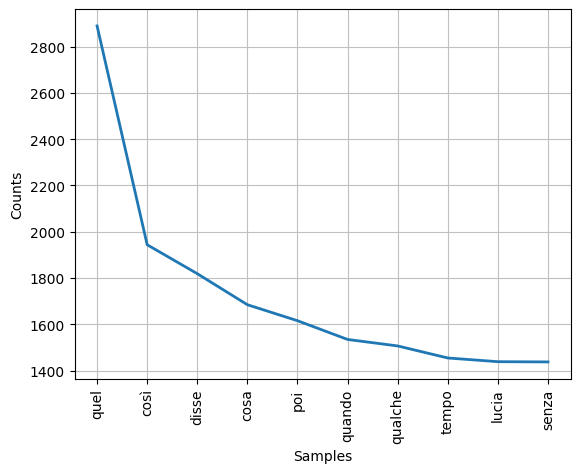

<Axes: xlabel='Samples', ylabel='Counts'>

In [23]:
freq_dist=nltk.FreqDist(flattened_corpus)
freq_dist.plot(10, cumulative=False)
